# High Performance Machine Learning lab
StarGAN for image-to-image translation in TensorFlow 2.3 Estimator API.

## Author: Paweł Rościszewski
  based on the [StarGAN Estimator example](https://github.com/tensorflow/gan/tree/master/tensorflow_gan/examples/stargan_estimator) by Wesley Qian

In [1]:
# !pip install -r requirements.txt
!python --version
!pip list | grep tensorflow

Python 3.7.5
You should consider upgrading via the '/home/student/MeeHPCML/venv/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from absl import flags

import tensorflow.compat.v1 as tf

import collections
import os
import sys

import cv2
import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

import tensorflow_gan as tfgan
import tensorflow_datasets as tfds

from tensorflow_gan.examples.stargan import network

from tensorflow_gan.examples.cyclegan import data_provider as cyclegan_dp

from matplotlib import pyplot as plt
%pylab inline

tf.disable_v2_behavior()
logger = tf.get_logger()
logger.propagate = False

W0526 13:10:09.646895 139828413290304 module_wrapper.py:138] From /home/student/.local/lib/python3.6/site-packages/tensorflow_gan/python/estimator/tpu_gan_estimator.py:42: The name tf.estimator.tpu.TPUEstimator is deprecated. Please use tf.compat.v1.estimator.tpu.TPUEstimator instead.

W0526 13:10:10.738104 139828413290304 deprecation.py:323] From /home/student/.local/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:96: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


Populating the interactive namespace from numpy and matplotlib


In [3]:
batch_size = 10  # The number of images in each batch.
patch_size = 128  # The patch size of images.

generator_lr = 1e-4  # The generator learning rate.
discriminator_lr = 1e-4  # The discriminator learning rate.
max_number_of_steps = 1000000  # The maximum number of gradient steps.
steps_per_eval = 1  # The number of steps after which evaluate the model.
adam_beta1 = 0.5  # Adam Beta 1 for the Adam optimizer.
adam_beta2 = 0.999  # Adam Beta 2 for the Adam optimizer.
gen_disc_step_ratio = 0.2  # Generator:Discriminator training step ratio.

override_generator_fn=None
override_discriminator_fn=None

master = ''  # Name of the TensorFlow master to use.
ps_tasks = 0  # The number of parameter servers. If the value is 0, then the parameters are handled locally by the worker.
task = 0  # The Task ID. This value is used when training with multiple workers to identify each worker.

In [4]:
HParams = collections.namedtuple('HParams', [
    'batch_size', 'patch_size', 'generator_lr',
    'discriminator_lr', 'max_number_of_steps', 'steps_per_eval', 'adam_beta1',
    'adam_beta2', 'gen_disc_step_ratio', 'master', 'ps_tasks', 'task'
])
hparams = HParams(batch_size, patch_size, generator_lr, discriminator_lr, max_number_of_steps, 
                  steps_per_eval, adam_beta1, adam_beta2, gen_disc_step_ratio, master, ps_tasks, task)

In [5]:
def provide_dataset(split, batch_size, patch_size, num_parallel_calls=None,
                    shuffle=True, domains=None):
    """Provides batches of CelebA image patches.

    Args:
      split: Either 'train' or 'test'.
      batch_size: The number of images in each batch.
      patch_size: Python int. The patch size to extract.
      num_parallel_calls: Number of threads dedicated to parsing.
      shuffle: Whether to shuffle.
      domains: Name of domains to transform between. Must be in Celeb A dataset.

    Returns:
      A tf.data.Dataset with:
        * images:  `Tensor` of size [batch_size, 32, 32, 3] and type tf.float32.
            Output pixel values are in [-1, 1].
        * labels: A `Tensor` of size [batch_size, 10] of one-hot label
            encodings with type tf.int32, or a `Tensor` of size [batch_size],
            depending on the value of `one_hot`.

    Raises:
      ValueError: If `split` isn't `train` or `test`.
    """
    ds = tfds.load('celeb_a:2.*.*', split=split, shuffle_files=shuffle, download=False,
                   data_dir='/ssd_local/hpml/tensorflow_datasets/')

    def _filter_pred(attribute):
        def _filter(element):
            return element['attributes'][attribute]

        return _filter

    dss = tuple([ds.filter(_filter_pred(attribute)) for attribute in domains])
    ds = tf.data.Dataset.zip(dss)

    def _preprocess(*elements):
        """Map elements to the example dicts expected by the model."""
        output_dict = {}
        num_domains = len(elements)
        for idx, (domain, elem) in enumerate(zip(domains, elements)):
            uint8_img = elem['image']
            patch = cyclegan_dp.full_image_to_patch(uint8_img, patch_size)
            label = tf.one_hot(idx, num_domains)
            output_dict[domain] = {'images': patch, 'labels': label}
        return output_dict

    ds = (ds
          .map(_preprocess, num_parallel_calls=num_parallel_calls)
          .cache()
          .repeat())
    if shuffle:
        ds = ds.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    ds = (ds
          .batch(batch_size, drop_remainder=True)
          .prefetch(tf.data.experimental.AUTOTUNE))

    return ds

In [6]:
def provide_data(split, batch_size, patch_size, num_parallel_calls=None,
                 shuffle=True, domains=None):
    """Provides batches of CelebA image patches.

    Args:
      split: Either 'train' or 'test'.
      batch_size: The number of images in each batch.
      patch_size: Python int. The patch size to extract.
      num_parallel_calls: Number of threads dedicated to parsing.
      shuffle: Whether to shuffle.
      domains: Name of domains to transform between. Must be in Celeb A dataset.

    Returns:
      A tf.data.Dataset with:
        * images:  `Tensor` of size [batch_size, patch_size, patch_size, 3] and
            type tf.float32. Output pixel values are in [-1, 1].
        * labels: A `Tensor` of size [batch_size, 10] of one-hot label
            encodings with type tf.int32, or a `Tensor` of size [batch_size],
            depending on the value of `one_hot`.

    Raises:
      ValueError: If `split` isn't `train` or `test`.
    """
    ds = provide_dataset(split, batch_size, patch_size, num_parallel_calls,
                         shuffle, domains)

    next_batch = tf.data.make_one_shot_iterator(ds).get_next()
    domains = next_batch.keys()
    images = [next_batch[domain]['images'] for domain in domains]
    labels = [next_batch[domain]['labels'] for domain in domains]

    return images, labels

In [7]:
def _get_optimizer(gen_lr, dis_lr, beta1, beta2):
    """Returns generator optimizer and discriminator optimizer.

    Args:
      gen_lr: A scalar float `Tensor` or a Python number.  The Generator learning
        rate.
      dis_lr: A scalar float `Tensor` or a Python number.  The Discriminator
        learning rate.
      beta1: A scalar float `Tensor` or a Python number. The beta1 parameter to
        the `AdamOptimizer`.
      beta2: A scalar float `Tensor` or a Python number. The beta2 parameter to
        the `AdamOptimizer`.

    Returns:
      A tuple of generator optimizer and discriminator optimizer.
    """
    gen_opt = tf.train.AdamOptimizer(
        gen_lr, beta1=beta1, beta2=beta2, use_locking=True)
    dis_opt = tf.train.AdamOptimizer(
        dis_lr, beta1=beta1, beta2=beta2, use_locking=True)
    return gen_opt, dis_opt

In [8]:
def _define_train_step(gen_disc_step_ratio):
    """Get the training step for generator and discriminator for each GAN step.

    Args:
      gen_disc_step_ratio: A python number. The ratio of generator to
        discriminator training steps.

    Returns:
      GANTrainSteps namedtuple representing the training step configuration.
    """

    if gen_disc_step_ratio <= 1:
        discriminator_step = int(1 / gen_disc_step_ratio)
        return tfgan.GANTrainSteps(1, discriminator_step)
    else:
        generator_step = int(gen_disc_step_ratio)
        return tfgan.GANTrainSteps(generator_step, 1)

In [9]:
def _get_summary_image(estimator, test_images_np):
    """Returns a numpy image of the generate on the test images."""
    num_domains = len(test_images_np)

    img_rows = []
    for img_np in test_images_np:
        def test_input_fn():
            dataset_imgs = [img_np] * num_domains  # pylint:disable=cell-var-from-loop
            dataset_lbls = [tf.one_hot([d], num_domains) for d in xrange(num_domains)]

            # Make into a dataset.
            dataset_imgs = np.stack(dataset_imgs)
            dataset_imgs = np.expand_dims(dataset_imgs, 1)
            dataset_lbls = tf.stack(dataset_lbls)
            unused_tensor = tf.zeros(num_domains)
            return tf.data.Dataset.from_tensor_slices(((dataset_imgs, dataset_lbls),
                                                       unused_tensor))

        prediction_iterable = estimator.predict(test_input_fn)
        predictions = [next(prediction_iterable) for _ in xrange(num_domains)]
        transform_row = np.concatenate([img_np] + predictions, 1)
        img_rows.append(transform_row)

    all_rows = np.concatenate(img_rows, 0)
    # Normalize` [-1, 1] to [0, 1].
    normalized_summary = (all_rows + 1.0) / 2.0
    return normalized_summary

In [10]:
# !wget -O test_image1.jpg https://static01.nyt.com/newsgraphics/2020/11/12/fake-people/4b806cf591a8a76adfc88d19e90c8c634345bf3d/fallbacks/mobile-03.jpg 
# !wget -O test_image2.jpg https://static01.nyt.com/newsgraphics/2020/11/12/fake-people/4b806cf591a8a76adfc88d19e90c8c634345bf3d/fallbacks/mobile-04.jpg
# !wget -O test_image3.jpg https://static01.nyt.com/newsgraphics/2020/11/12/fake-people/4b806cf591a8a76adfc88d19e90c8c634345bf3d/fallbacks/mobile-05.jpg
    
# !convert test_image1.jpg -resize 128x128 test_image1.png
# !convert test_image2.jpg -resize 128x128 test_image2.png
# !convert test_image3.jpg -resize 128x128 test_image3.png

# !file test_image1.png
# !file test_image2.png
# !file test_image3.png

Estimator's model_fn (<function StarGANEstimator.__init__.<locals>._model_fn at 0x7f2bc45c6c80>) includes params argument, but params are not passed to Estimator.
From /home/student/.local/lib/python3.6/site-packages/tensorflow/python/training/training_util.py:236: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
From /home/student/.local/lib/python3.6/site-packages/tensorflow_gan/examples/stargan/layers.py:44: conv2d (from tensorflow.python.keras.legacy_tf_layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
From /home/student/.local/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:424: Layer.apply (from tensorflow.python.keras.engine.base_la

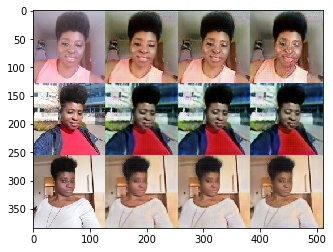

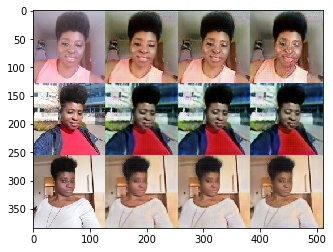

PERFORMANCE METRICS: Average step execution time: 139.9128s
PERFORMANCE METRICS: Average image rate: 0.0715 img/s


It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 7577 vs previous value: 7577. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


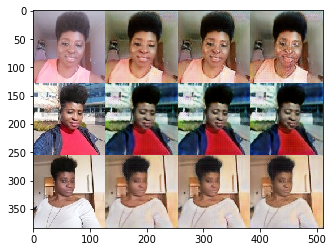

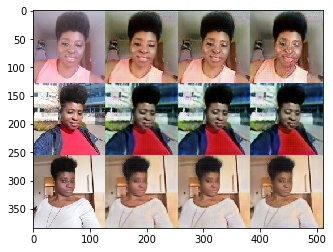

PERFORMANCE METRICS: Average step execution time: 122.2792s
PERFORMANCE METRICS: Average image rate: 0.0818 img/s


From /home/student/.local/lib/python3.6/site-packages/tensorflow/python/training/saver.py:971: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


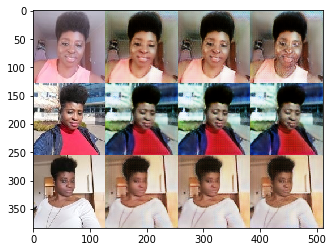

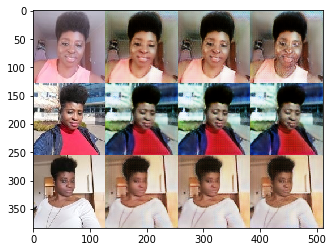

PERFORMANCE METRICS: Average step execution time: 116.3867s
PERFORMANCE METRICS: Average image rate: 0.0859 img/s


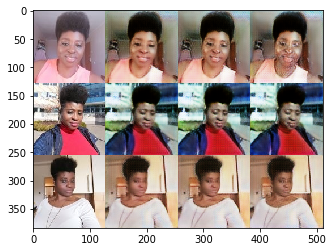

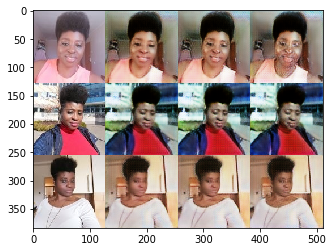

PERFORMANCE METRICS: Average step execution time: 116.6497s
PERFORMANCE METRICS: Average image rate: 0.0857 img/s


It seems that global step (tf.train.get_global_step) has not been increased. Current value (could be stable): 7583 vs previous value: 7583. You could increase the global step by passing tf.train.get_global_step() to Optimizer.apply_gradients or Optimizer.minimize.


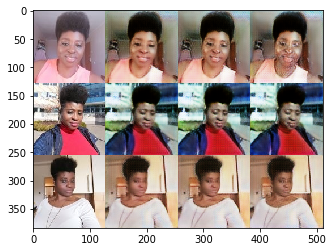

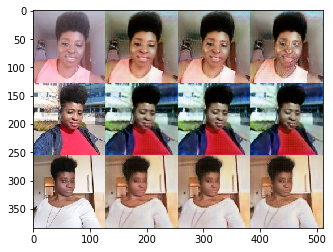

PERFORMANCE METRICS: Average step execution time: 114.5077s
PERFORMANCE METRICS: Average image rate: 0.0873 img/s


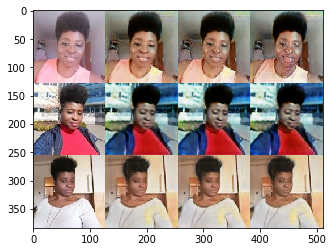

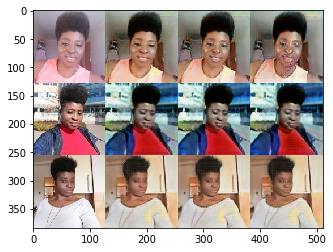

PERFORMANCE METRICS: Average step execution time: 115.8806s
PERFORMANCE METRICS: Average image rate: 0.0863 img/s


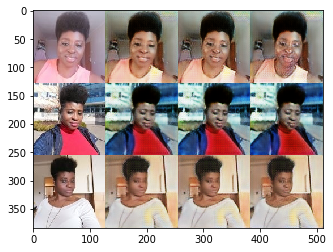

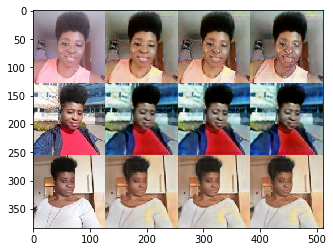

PERFORMANCE METRICS: Average step execution time: 114.3553s
PERFORMANCE METRICS: Average image rate: 0.0874 img/s


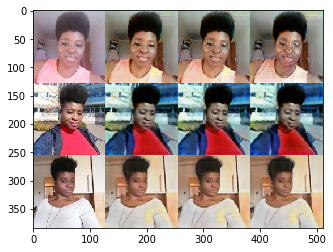

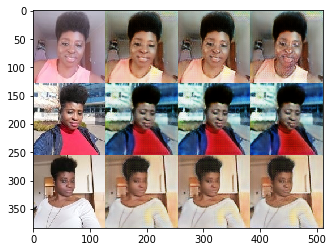

PERFORMANCE METRICS: Average step execution time: 114.5200s
PERFORMANCE METRICS: Average image rate: 0.0873 img/s


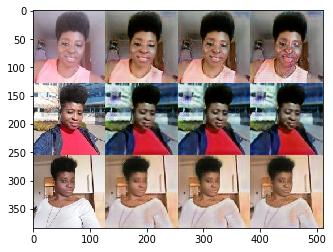

In [ ]:
# Make sure steps integers are consistent.
if hparams.max_number_of_steps % hparams.steps_per_eval != 0:
    raise ValueError('`max_number_of_steps` must be divisible by '
                     '`steps_per_eval`.')

# Create optimizers.
gen_opt, dis_opt = _get_optimizer(hparams.generator_lr,
                                  hparams.discriminator_lr,
                                  hparams.adam_beta1, hparams.adam_beta2)

config_proto = tf.ConfigProto()
config_proto.gpu_options.allow_growth = True
dev_fn = lambda op: '/cpu:0'
run_config = tf.estimator.RunConfig(session_config=config_proto, device_fn=dev_fn)
      

# Create estimator.
stargan_estimator = tfgan.estimator.StarGANEstimator(
    model_dir='models',
    generator_fn=override_generator_fn or network.generator,
    discriminator_fn=override_discriminator_fn or network.discriminator,
    loss_fn=tfgan.stargan_loss,
    generator_optimizer=gen_opt,
    discriminator_optimizer=dis_opt,
    get_hooks_fn=tfgan.get_sequential_train_hooks(
        _define_train_step(hparams.gen_disc_step_ratio)),
    add_summaries=tfgan.estimator.SummaryType.IMAGES,
    config=run_config)

# Get input function for training and test images.
train_input_fn = lambda: provide_data(
    'train', hparams.batch_size, hparams.patch_size,
    domains=('Narrow_Eyes', 'Oval_Face', 'Goatee'))

test_images_np = np.array([cv2.imread('test_image1.png') / 255.0 * 2 - 1,
                          cv2.imread('test_image2.png') / 255.0 * 2 - 1,
                          cv2.imread('test_image3.png') / 255.0 * 2 - 1],
                          dtype=np.float32)
test_images_np = test_images_np[:,:,:,::-1]


def formatter_log(tensors):
    summary_img = _get_summary_image(stargan_estimator, test_images_np)
    plt.imshow(summary_img)
    plt.show()
    return f'Current Iteration: {tensors["total_iterations"]}'

tensors_to_log = {"total_iterations": "global_step"}

logging_hook = tf.train.LoggingTensorHook(tensors_to_log ,
                                          every_n_iter=hparams.steps_per_eval,
                                          formatter=formatter_log)

import time
class PerformanceMeasurementHook(tf.train.SessionRunHook):
    def __init__(self, batch_size, every_steps=5):
        self.every_steps = every_steps
        self.counter = 0
        self.batch_size = batch_size
        
    def begin(self):
        self.start = time.time()
        
    def after_run(self, run_context, run_values):
        self.counter+=1
        if (self.counter<self.every_steps):
            return
        
        end = time.time()
        
        self.counter=0
        
        diff = end - self.start
        
        avg_step = diff/self.every_steps
        print(f"PERFORMANCE METRICS: Average step execution time: {avg_step:.4f}s")
        
        image_rate =  (self.every_steps * self.batch_size) / diff
        print(f"PERFORMANCE METRICS: Average image rate: {image_rate:.4f} img/s")
        self.start = time.time()

performace_hook = PerformanceMeasurementHook(batch_size=hparams.batch_size, every_steps=2)

profiler_hook = tf.estimator.ProfilerHook(save_steps=True, output_dir='./', show_dataflow=True, show_memory=True)

res = stargan_estimator.train(train_input_fn,hooks=[logging_hook, performace_hook, profiler_hook], max_steps=hparams.max_number_of_steps)

